# The study for HMC BIW PROJECT  

## M/L is used to estimate the value with parameters.  
## 


In [1]:
# import libraries
from __future__ import absolute_import, division, print_function, unicode_literals

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# other utiles
import matplotlib.pyplot as plt
from  IPython import display
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib

In [2]:
# check the tensorflow version
print(tf.__version__)

2.1.0


In [3]:
# read training dataset
# dataset_org = pd.read_csv(r'F:\CON_2019_HMC_PGD-MINESET\Second_model\Case2\whe_ro_to_send\New_Testing_parameters_max.csv')
dataset_org = pd.read_csv(r'F:\CON_2019_HMC_PGD-MINESET\Second_model\Case2\Training_parameters_max.csv')

# make an instance for dataset
dataset = dataset_org
# extract the columns from the dataset
column_names = dataset.columns

lst_max = (dataset.max(0).tail(2))
lst_min = (dataset.min(0).tail(2))

min_Area = lst_min[0]
max_Area = lst_max[0]

min_Disp = lst_min[1] 
max_Disp = lst_max[1]

print(min_Area,max_Area,min_Disp,max_Disp)
dataset.head()

56.5625 14282.90625 89.13494873 124.75805659999999


,HLAYER01,HLAYER02,HLAYER03,HLAYER04,HLAYER05,HLAYER06,HLAYER07,HLAYER08,HLAYER09,HLAYER10,...,L10_FLG,L10_WALL,L11_CNR,L11_FLG,L11_WALL,L12_CNR,L12_FLG,L12_WALL,Area,Disp
0,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,...,1470,1470,1470,1470,1470,1470,1470,1470,14282.90625,120.782715
1,1180,1180,590,780,1180,980,1180,980,1180,780,...,980,1470,980,1180,780,590,1470,1180,1328.96875,99.054810
2,1470,980,1180,780,1180,1180,590,780,980,1180,...,1470,780,1180,1180,980,590,1180,780,2852.84375,103.067932
3,1470,980,780,1180,590,1470,590,1180,780,1180,...,780,780,780,780,980,780,590,1180,227.59375,94.955994
4,780,1470,1470,1470,780,1180,1470,780,1180,1470,...,780,980,1180,590,780,980,780,590,73.28125,93.011719


# 1. M/L model for Area

In [4]:
# Define Functions
model = None
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

def build_model():
    model = keras.Sequential([
      layers.Dense(56, activation='relu', 
                   kernel_regularizer=keras.regularizers.l2(0.01), 
                   input_shape=[len(train_dataset.keys())]),
      layers.Dense(56, activation='relu', 
                   kernel_regularizer=keras.regularizers.l2(0.001)
                   ), 
      layers.Dense(1)
      ])
    #optimizer = tf.keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
    #optimizer = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    #optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    #optimizer = tf.keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #optimizer = tf.keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #optimizer = tf.keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    
    model.compile(
      loss='mae',
      optimizer=optimizer,
      # 'mae', 'mse', 'mape',
      metrics=['mae'])

    return model  

# Training
def training(EPOCHS=1000, model=model):
    # EPOCHS = 1000
    # print("% : Training : start", model)
    history = model.fit(
                          normed_train_data, train_labels,
                          epochs=EPOCHS, validation_split = 0.2, verbose=0,
                          callbacks=[tfdocs.modeling.EpochDots()]
                          )
    # print("% : Training : end", model)
    
    # early stop by val_mae
    early_stop = keras.callbacks.EarlyStopping(monitor='mae', patience=10)
    early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    test_mae_score, test_mae_score = model.evaluate(  normed_test_data, test_labels  )                    
    return model, history, early_history        

In [5]:
# dataset = pd.read_csv(r'F:\CON_2019_HMC_PGD-MINESET\Second_model\Case2\whe_ro_to_send\New_Testing_parameters_max.csv')
dataset_org = pd.read_csv(r'F:\CON_2019_HMC_PGD-MINESET\Second_model\Case2\Training_parameters_max.csv')
lst_pop = [ "Area", "Disp" ]
target = "Area"
for pop in lst_pop:
    if pop == target:
        print(target)
        pass
    else:
        dataset.pop(pop)

train_dataset = dataset.sample(frac=0.7)
test_dataset  = dataset.drop(train_dataset.index)	

# make an instance for dataframe as "train_stats"
train_stats = train_dataset.describe()
# delete "Area" column from "train_stats"
train_stats.pop( target )

train_stats = train_stats.transpose()
# train_stats.tail()

# make instances for dataset without the QoI
train_labels = train_dataset.pop( target )
test_labels  =  test_dataset.pop( target )    

normed_train_data = norm( train_dataset )
normed_test_data  = norm( test_dataset  )

# create the model instance 
EPOCHS = 1000
model_Area = build_model()
model_Area, model_Area_history, model_Area_early_history = training(EPOCHS, model=model_Area)



Area

Epoch: 0, loss:1476.6401,  mae:1476.0400,  val_loss:1447.8379,  val_mae:1447.2179,  
....................................................................................................
Epoch: 100, loss:312.1752,  mae:306.8336,  val_loss:486.1792,  val_mae:480.8331,  
....................................................................................................
Epoch: 200, loss:144.9011,  mae:138.2582,  val_loss:453.7490,  val_mae:447.0936,  
....................................................................................................
Epoch: 300, loss:73.4224,  mae:65.9826,  val_loss:474.0255,  val_mae:466.5797,  
....................................................................................................
Epoch: 400, loss:45.2643,  mae:37.3815,  val_loss:500.2001,  val_mae:492.3161,  
....................................................................................................
Epoch: 500, loss:34.7913,  mae:26.6780,  val_loss:516.8989,  val_mae:508.784

Text(0, 0.5, 'MAE [Area]')

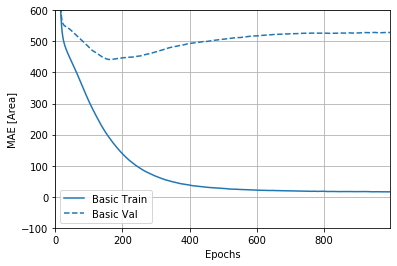

In [6]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': model_Area_history}, metric = "mae")
plt.ylim([-100, 600])
plt.ylabel('MAE [Area]')

Text(0, 0.5, 'MAE [Area]')

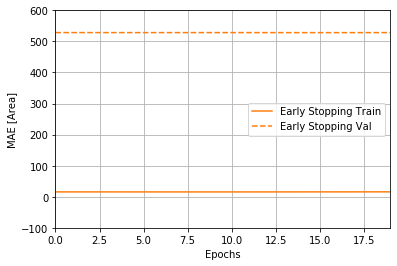

In [7]:
plotter.plot({'Early Stopping': model_Area_early_history}, metric = "mae")
plt.ylim([-100, 600])
plt.ylabel('MAE [Area]')

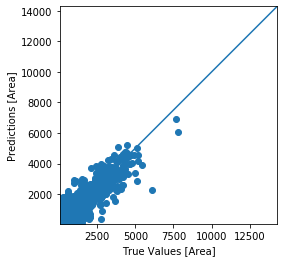

In [23]:
# model evaluate by curve
test_predictions = model_Area.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Area]')
plt.ylabel('Predictions [Area]')
lims = [lst_min[0]-1, lst_max[0]+1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [25]:
# dataset = pd.read_csv(r'F:\CON_2019_HMC_PGD-MINESET\Second_model\Case2\whe_ro_to_send\New_Testing_parameters_max.csv')
dataset = pd.read_csv(r'F:\CON_2019_HMC_PGD-MINESET\Second_model\Case2\Training_parameters_max.csv')
lst_pop = [ "Area", "Disp" ]
target = "Disp"
for pop in lst_pop:
    if pop == target:
        print(target)
        pass
    else:
        dataset.pop(pop)

train_dataset = dataset.sample(frac=0.7)
test_dataset = dataset.drop(train_dataset.index)	

# make an instance for dataframe as "train_stats"
train_stats = train_dataset.describe()
# delete "Area" column from "train_stats"
train_stats.pop( target )

train_stats = train_stats.transpose()
# train_stats.tail()

# make instances for dataset without the QoI
train_labels = train_dataset.pop( target )
test_labels  =  test_dataset.pop( target )    

normed_train_data = norm( train_dataset )
normed_test_data  = norm( test_dataset  )

# create the model instance 
EPOCHS = 5000
model_Disp = build_model()
model_Disp, model_Disp_history, model_Disp_early_history = training(EPOCHS, model=model_Disp)



Disp

Epoch: 0, loss:95.7925,  mae:95.1775,  val_loss:91.7204,  val_mae:91.0728,  
....................................................................................................
Epoch: 100, loss:1.6022,  mae:0.7343,  val_loss:6.9799,  val_mae:6.1130,  
....................................................................................................
Epoch: 200, loss:1.3081,  mae:0.6246,  val_loss:6.2083,  val_mae:5.5255,  
....................................................................................................
Epoch: 300, loss:1.1662,  mae:0.6021,  val_loss:5.6340,  val_mae:5.0701,  
....................................................................................................
Epoch: 400, loss:1.1304,  mae:0.6454,  val_loss:5.1204,  val_mae:4.6356,  
....................................................................................................
Epoch: 500,loss:1.0808,  mae:0.6507,  val_loss:4.7943,  val_mae:4.3640,  
......................................

Text(0, 0.5, 'MAE [Displacement]')

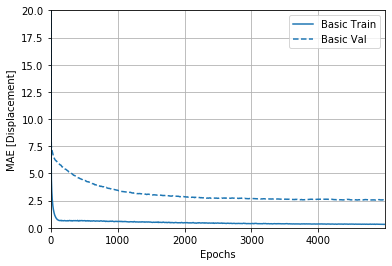

In [26]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': model_Disp_history}, metric = "mae")
plt.ylim([0, 20])
plt.ylabel('MAE [Displacement]')

Text(0, 0.5, 'MAE [Displacement]')

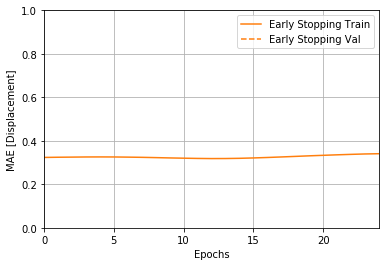

In [27]:
plotter.plot({'Early Stopping': model_Disp_early_history}, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE [Displacement]')

744


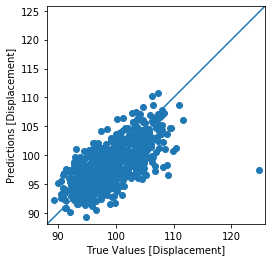

In [28]:
# model evaluate by curve
test_predictions = model_Disp.predict(normed_test_data).flatten()
print(len(test_predictions))
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Displacement]')
plt.ylabel('Predictions [Displacement]')
lims = [lst_min[1]-1, lst_max[1]+1]
# lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [29]:
# model evaluate 
loss_Area, mae_Area = model_Area.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: Area {:5.2f} [mm2]".format(mae_Area))
loss_Disp, mae_Disp = model_Disp.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: Disp {:5.2f} [mm]".format(mae_Disp))


744/744 - 0s - loss: 1508.1706 - mae: 1499.8165
Testing set Mean Abs Error: Area 1499.82 [mm2]
744/744 - 0s - loss: 2.7782 - mae: 2.6239
Testing set Mean Abs Error: Disp  2.62 [mm]


# 2. M/L model for Pelvic displacement


# 3. Optimization by Generic Algorithm

In [30]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Sequential, load_model
from scipy import optimize
import time


In [31]:
# Number of Curve points
point = 2375
# Number of variables 
var = 56

In [32]:
# predict_func
# Mean square error between test and prediction

def predict_func(column_names):

    for i in range( 0, len(column_names) ):
        if column_names[i] <= 515 :
            column_names[i] = 440
        elif 515 < column_names[i] <= 685:
            column_names[i] = 590
        elif 685 < column_names[i] <= 880:
            column_names[i] = 780
        elif 880 < column_names[i] <= 1080:
            column_names[i] = 980
        elif 1080 < column_names[i] <= 1290:
            column_names[i] = 1180
        elif 1290 < column_names[i] :
            column_names[i] = 1400
        

    PARTNO01 = column_names[0]
    PARTNO02 = column_names[1]
    PARTNO03 = column_names[2]
    PARTNO04 = column_names[3]
    PARTNO05 = column_names[4]
    PARTNO06 = column_names[5]
    PARTNO07 = column_names[6]
    PARTNO08 = column_names[7]
    PARTNO09 = column_names[8]
    PARTNO10 = column_names[9]

    PARTNO11 = column_names[10]
    PARTNO12 = column_names[11]
    PARTNO13 = column_names[12]
    PARTNO14 = column_names[13]
    PARTNO15 = column_names[14]
    PARTNO16 = column_names[15]
    PARTNO17 = column_names[16]
    PARTNO18 = column_names[17]
    PARTNO19 = column_names[18]
    PARTNO20 = column_names[19]

    PARTNO21 = column_names[20]
    PARTNO22 = column_names[21]
    PARTNO23 = column_names[22]
    PARTNO24 = column_names[23]
    PARTNO25 = column_names[24]
    PARTNO26 = column_names[25]
    PARTNO27 = column_names[26]
    PARTNO28 = column_names[27]
    PARTNO29 = column_names[28]
    PARTNO30 = column_names[29]

    PARTNO31 = column_names[30]
    PARTNO32 = column_names[31]
    PARTNO33 = column_names[32]
    PARTNO34 = column_names[33]
    PARTNO35 = column_names[34]
    PARTNO36 = column_names[35]
    PARTNO37 = column_names[36]
    PARTNO38 = column_names[37]
    PARTNO39 = column_names[38]
    PARTNO40 = column_names[39]

    PARTNO41 = column_names[40]
    PARTNO42 = column_names[41]
    PARTNO43 = column_names[42]
    PARTNO44 = column_names[43]
    PARTNO45 = column_names[44]

    PARTNO46 = column_names[45]
    PARTNO47 = column_names[46]
    PARTNO48 = column_names[47]
    PARTNO49 = column_names[48]
    PARTNO50 = column_names[49]

    PARTNO51 = column_names[50]
    PARTNO52 = column_names[51]
    PARTNO53 = column_names[52]
    PARTNO54 = column_names[53]
    PARTNO55 = column_names[54]
    PARTNO56 = column_names[55]

    # Prediction data standardize
    # Common variables
    PARTNO01N = norm(PARTNO01)
    PARTNO02N = norm(PARTNO02)
    PARTNO03N = norm(PARTNO03)
    PARTNO04N = norm(PARTNO04) 
    PARTNO05N = norm(PARTNO05)
    PARTNO06N = norm(PARTNO06)
    PARTNO07N = norm(PARTNO07)
    PARTNO08N = norm(PARTNO08)
    PARTNO09N = norm(PARTNO09) 
    PARTNO10N = norm(PARTNO10)

    PARTNO11N = norm(PARTNO11)
    PARTNO12N = norm(PARTNO12)
    PARTNO13N = norm(PARTNO13)
    PARTNO14N = norm(PARTNO14) 
    PARTNO15N = norm(PARTNO15)
    PARTNO16N = norm(PARTNO16)
    PARTNO17N = norm(PARTNO17)
    PARTNO18N = norm(PARTNO18)
    PARTNO19N = norm(PARTNO19) 
    PARTNO20N = norm(PARTNO20)

    PARTNO21N = norm(PARTNO21)
    PARTNO22N = norm(PARTNO22)
    PARTNO23N = norm(PARTNO23)
    PARTNO24N = norm(PARTNO24) 
    PARTNO25N = norm(PARTNO25)
    PARTNO26N = norm(PARTNO26)
    PARTNO27N = norm(PARTNO27)
    PARTNO28N = norm(PARTNO28)
    PARTNO29N = norm(PARTNO29) 
    PARTNO30N = norm(PARTNO30)

    PARTNO31N = norm(PARTNO31)
    PARTNO32N = norm(PARTNO32)
    PARTNO33N = norm(PARTNO33)
    PARTNO34N = norm(PARTNO34) 
    PARTNO35N = norm(PARTNO35)
    PARTNO36N = norm(PARTNO36)
    PARTNO37N = norm(PARTNO37)
    PARTNO38N = norm(PARTNO38)
    PARTNO39N = norm(PARTNO39) 
    PARTNO40N = norm(PARTNO40)

    PARTNO41N = norm(PARTNO41)
    PARTNO42N = norm(PARTNO42)
    PARTNO43N = norm(PARTNO43)
    PARTNO44N = norm(PARTNO44) 
    PARTNO45N = norm(PARTNO45)
    PARTNO46N = norm(PARTNO46)

    PARTNO47N = norm(PARTNO47)
    PARTNO48N = norm(PARTNO48)
    PARTNO49N = norm(PARTNO49)
    PARTNO50N = norm(PARTNO50) 
    PARTNO51N = norm(PARTNO51)
    PARTNO52N = norm(PARTNO52)
    PARTNO53N = norm(PARTNO53)
    PARTNO54N = norm(PARTNO54)
    PARTNO55N = norm(PARTNO55) 
    PARTNO56N = norm(PARTNO56)    

    # Result of prediction data   
    predict_cur_Area = model_Area.predict([[
        PARTNO01N,        PARTNO02N,        PARTNO03N,        PARTNO04N,        PARTNO05N, \
        PARTNO06N,        PARTNO07N,        PARTNO08N,        PARTNO09N,        PARTNO10N, \
        PARTNO11N,        PARTNO12N,        PARTNO13N,        PARTNO14N,        PARTNO15N, \
        PARTNO16N,        PARTNO17N,        PARTNO18N,        PARTNO19N,        PARTNO20N, \
        PARTNO21N,        PARTNO22N,        PARTNO23N,        PARTNO24N,        PARTNO25N, \
        PARTNO26N,        PARTNO27N,        PARTNO28N,        PARTNO29N,        PARTNO30N, \
        PARTNO31N,        PARTNO32N,        PARTNO33N,        PARTNO34N,        PARTNO35N, \
        PARTNO36N,        PARTNO37N,        PARTNO38N,        PARTNO39N,        PARTNO40N, \
        PARTNO41N,        PARTNO42N,        PARTNO43N,        PARTNO44N,        PARTNO45N, \
        PARTNO46N,        PARTNO47N,        PARTNO48N,        PARTNO49N,        PARTNO50N, \
        PARTNO51N,        PARTNO52N,        PARTNO53N,        PARTNO54N,        PARTNO55N, \
        PARTNO56N
        ]])[0]
    predict_cur_Disp = model_Disp.predict([[
        PARTNO01N,        PARTNO02N,        PARTNO03N,        PARTNO04N,        PARTNO05N, \
        PARTNO06N,        PARTNO07N,        PARTNO08N,        PARTNO09N,        PARTNO10N, \
        PARTNO11N,        PARTNO12N,        PARTNO13N,        PARTNO14N,        PARTNO15N, \
        PARTNO16N,        PARTNO17N,        PARTNO18N,        PARTNO19N,        PARTNO20N, \
        PARTNO21N,        PARTNO22N,        PARTNO23N,        PARTNO24N,        PARTNO25N, \
        PARTNO26N,        PARTNO27N,        PARTNO28N,        PARTNO29N,        PARTNO30N, \
        PARTNO31N,        PARTNO32N,        PARTNO33N,        PARTNO34N,        PARTNO35N, \
        PARTNO36N,        PARTNO37N,        PARTNO38N,        PARTNO39N,        PARTNO40N, \
        PARTNO41N,        PARTNO42N,        PARTNO43N,        PARTNO44N,        PARTNO45N, \
        PARTNO46N,        PARTNO47N,        PARTNO48N,        PARTNO49N,        PARTNO50N, \
        PARTNO51N,        PARTNO52N,        PARTNO53N,        PARTNO54N,        PARTNO55N, \
        PARTNO56N
        ]])[0]    
 
    
    lst_max = (dataset.max(0).tail(2))
    lst_min = (dataset.min(0).tail(2))

    min_Area = lst_min[0]
    max_Area = lst_max[0]

    min_Disp = lst_min[1] 
    max_Disp = lst_max[1]

    norm_Area = (predict_cur_Area - min_Area)/(max_Area - min_Area)
    norm_Disp = (predict_cur_Disp - min_Disp)/(max_Disp - min_Disp)
    print(predict_cur_Area, predict_cur_Disp)

    weight1 = 1.0
    weight2 = 2.0

    return   weight1 * norm_Area + weight2 * norm_Disp


In [33]:
# bnds; doundary conditions
# Parameter of Boundary conditions
bnds = [( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ),                       
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ),
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ),
        ( 440, 1400 )
]
print(len(bnds))

56


In [34]:
from scipy import optimize
# best1bin
result_best1bin = optimize.differential_evolution(predict_func, bnds, strategy='best1bin', init='latinhypercube')



[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[2686.944] [97.19683]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[-1170.3362] [85.38497]
[2686.944] [97.196

In [35]:
# Get minimize parameters
minimum_best1bin_x = result_best1bin.x
minimum_best1bin_f = result_best1bin.fun
minimum_best1bin_x, minimum_best1bin_f

(array([1030.10963186,  443.31210963,  574.0524179 ,  996.59819663,
        1071.53154762, 1103.08860316, 1367.21472367, 1167.10558392,
         621.58167797,  970.26100508,  917.15066695,  516.08675056,
         952.30660157, 1062.08741287, 1053.36229828, 1305.95412406,
         806.24512462,  797.86814678,  706.52950638,  482.77488015,
        1399.56855868,  569.82847102,  940.62017101,  500.10385066,
         571.65167376,  668.94504329, 1366.61269479, 1002.30705559,
         934.49928573, 1010.40076962,  576.79645404, 1146.50847956,
         929.19686179, 1090.59641456,  824.88693316,  705.95617578,
        1106.85512141,  943.4014331 ,  895.34307268, 1061.70812184,
         743.860196  , 1053.42759859,  947.44331267,  549.35998668,
         459.18522763, 1039.63857476, 1208.59478056, 1004.08451298,
        1326.65314333,  939.47357019,  900.20590504,  665.99772102,
         737.23513938, 1310.3171001 ,  495.08538136, 1337.68049635]),
 -2.2109181880950928)

In [36]:
for i in range( 0, len(minimum_best1bin_x) ):
    if minimum_best1bin_x[i] <= 515 :
        minimum_best1bin_x[i] = 440
    elif 515 < minimum_best1bin_x[i] <= 685:
        minimum_best1bin_x[i] = 590
    elif 685 < minimum_best1bin_x[i] <= 880:
        minimum_best1bin_x[i] = 780
    elif 880 < minimum_best1bin_x[i] <= 1080:
        minimum_best1bin_x[i] = 980
    elif 1080 < minimum_best1bin_x[i] <= 1290:
        minimum_best1bin_x[i] = 1180
    elif 1290 < minimum_best1bin_x[i] :
        minimum_best1bin_x[i] = 1400
minimum_best1bin_x        

array([ 980.,  440.,  590.,  980.,  980., 1180., 1400., 1180.,  590.,
        980.,  980.,  590.,  980.,  980.,  980., 1400.,  780.,  780.,
        780.,  440., 1400.,  590.,  980.,  440.,  590.,  590., 1400.,
        980.,  980.,  980.,  590., 1180.,  980., 1180.,  780.,  780.,
       1180.,  980.,  980.,  980.,  780.,  980.,  980.,  590.,  440.,
        980., 1180.,  980., 1400.,  980.,  980.,  590.,  780., 1400.,
        440., 1400.])

In [37]:
for i in range( 0, len(minimum_best1bin_x) ):
    if minimum_best1bin_x[i] <= 515 : 
        minimum_best1bin_x[i] = 11380000
    elif 515 < minimum_best1bin_x[i] <= 685:
        minimum_best1bin_x[i] = 11130000
    elif 685 < minimum_best1bin_x[i] <= 880:
        minimum_best1bin_x[i] = 11160000
    elif 880 < minimum_best1bin_x[i] <= 1080:
        minimum_best1bin_x[i] = 11190000
    elif 1080 < minimum_best1bin_x[i] <= 1290:
        minimum_best1bin_x[i] = 11210000
    elif 1290 < minimum_best1bin_x[i] :
        minimum_best1bin_x[i] = 60101030
minimum_best1bin_x        

array([11190000., 11380000., 11130000., 11190000., 11190000., 11210000.,
       60101030., 11210000., 11130000., 11190000., 11190000., 11130000.,
       11190000., 11190000., 11190000., 60101030., 11160000., 11160000.,
       11160000., 11380000., 60101030., 11130000., 11190000., 11380000.,
       11130000., 11130000., 60101030., 11190000., 11190000., 11190000.,
       11130000., 11210000., 11190000., 11210000., 11160000., 11160000.,
       11210000., 11190000., 11190000., 11190000., 11160000., 11190000.,
       11190000., 11130000., 11380000., 11190000., 11210000., 11190000.,
       60101030., 11190000., 11190000., 11130000., 11160000., 60101030.,
       11380000., 60101030.])

In [38]:
for id in minimum_best1bin_x :
    print(id)

11190000.0
11380000.0
11130000.0
11190000.0
11190000.0
11210000.0
60101030.0
11210000.0
11130000.0
11190000.0
11190000.0
11130000.0
11190000.0
11190000.0
11190000.0
60101030.0
11160000.0
11160000.0
11160000.0
11380000.0
60101030.0
11130000.0
11190000.0
11380000.0
11130000.0
11130000.0
60101030.0
11190000.0
11190000.0
11190000.0
11130000.0
11210000.0
11190000.0
11210000.0
11160000.0
11160000.0
11210000.0
11190000.0
11190000.0
11190000.0
11160000.0
11190000.0
11190000.0
11130000.0
11380000.0
11190000.0
11210000.0
11190000.0
60101030.0
11190000.0
11190000.0
11130000.0
11160000.0
60101030.0
11380000.0
60101030.0
